In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras.callbacks import ReduceLROnPlateau

# Function to read and convert images to numpy arrays
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))


In [2]:
# Define directories for image data
directory_benign_train = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/train/benign'
directory_malignant_train = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/train/malignant'
directory_benign_test = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/test/benign'
directory_malignant_test = 'C:/Users/Yogesh S A/Desktop/skin cancer1/input/test/malignant'

# Load train images
img_benign_train = [read(os.path.join(directory_benign_train, filename)) for filename in os.listdir(directory_benign_train)]
img_malignant_train = [read(os.path.join(directory_malignant_train, filename)) for filename in os.listdir(directory_malignant_train)]

# Load test images
img_benign_test = [read(os.path.join(directory_benign_test, filename)) for filename in os.listdir(directory_benign_test)]
img_malignant_test = [read(os.path.join(directory_malignant_test, filename)) for filename in os.listdir(directory_malignant_test)]

# Convert lists of images to NumPy arrays
X_benign_train = np.array(img_benign_train, dtype='uint8')
X_malignant_train = np.array(img_malignant_train, dtype='uint8')

X_benign_test = np.array(img_benign_test, dtype='uint8')
X_malignant_test = np.array(img_malignant_test, dtype='uint8')


In [3]:
# Create labels
y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Merging data to form complete training and test sets
X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0) 
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)


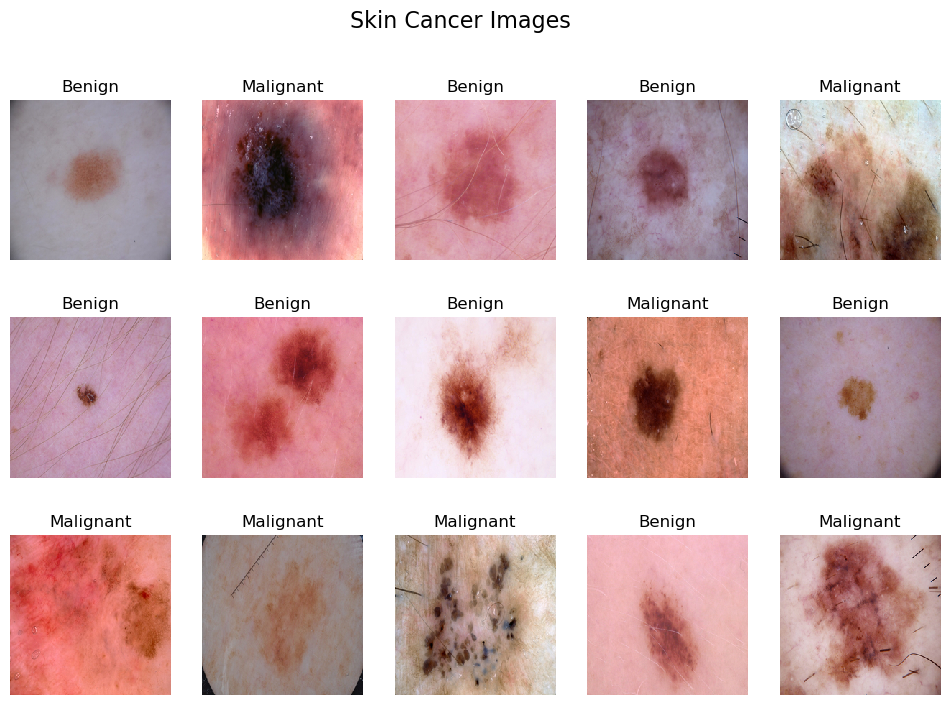

In [4]:
# Shuffle the data
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)

X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)

X_test = X_test[s2]
y_test = y_test[s2]

# Visualize a subset of the images
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
fig.suptitle('Skin Cancer Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    if y_train[i] == 0:
        label = 'Benign'
    else:
        label = 'Malignant'
    
    ax.imshow(X_train[i], interpolation='nearest')
    ax.set_title(label)
    ax.axis('off')

plt.show()


In [5]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0


In [6]:
# Create MobileNetV2 base model
mobilenetv2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [7]:
def build_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential()
    model.add(mobilenetv2_base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the MobileNetV2 model
mobilenetv2_model = build_mobilenetv2_model()


In [ ]:
# Create a learning rate annealer callback
learning_rate_annealer = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=1e-7)

# Train the MobileNetV2 model
history_mobilenetv2 = mobilenetv2_model.fit(X_train,
                                            y_train,
                                            validation_split=0.2,
                                            epochs=50,
                                            batch_size=64,
                                            verbose=1,
                                            callbacks=[learning_rate_annealer])


Epoch 1/50
33/33 [==============================] - 165s 5s/step - loss: 0.3743 - accuracy: 0.8260 - val_loss: 5.3884 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - 143s 4s/step - loss: 0.2488 - accuracy: 0.8862 - val_loss: 10.5714 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - 145s 4s/step - loss: 0.1844 - accuracy: 0.9118 - val_loss: 5.4654 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 4/50
33/33 [==============================] - 146s 4s/step - loss: 0.2020 - accuracy: 0.9208 - val_loss: 0.9242 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 5/50
33/33 [==============================] - 152s 5s/step - loss: 0.1450 - accuracy: 0.9507 - val_loss: 4.5042 - val_accuracy: 0.5644 - lr: 0.0010
Epoch 6/50
33/33 [==============================] - 150s 5s/step - loss: 0.1139 - accuracy: 0.9550 - val_loss: 7.0658 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 7/50
33/33 [==============================] - 155s 5s/step - loss: 0.

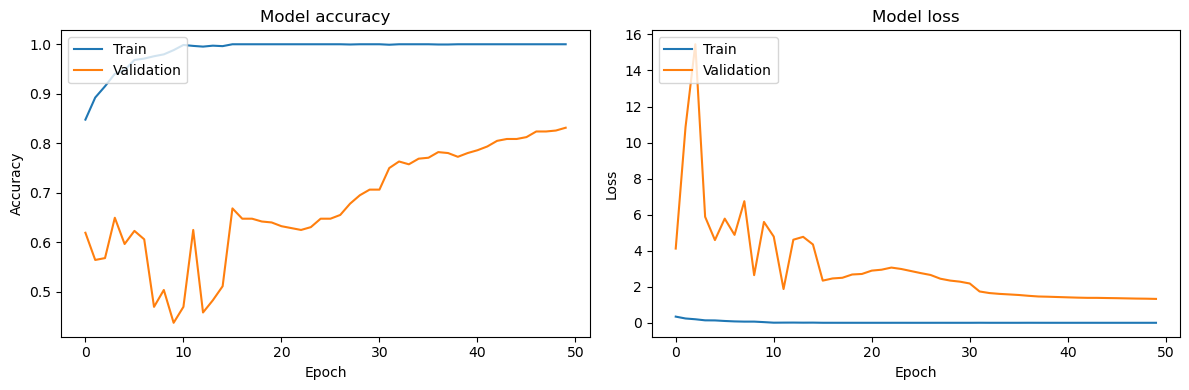

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['accuracy'])
plt.plot(history_mobilenetv2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['loss'])
plt.plot(history_mobilenetv2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = mobilenetv2_model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


In [1]:
# Make predictions on test data
y_pred_probabilities = mobilenetv2_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Convert true labels back from one-hot encoding
y_true_classes = np.argmax(y_test, axis=1)

# Shuffle test data for better visualization
s3 = np.arange(X_test.shape[0])
np.random.shuffle(s3)

X_test_shuffled = X_test[s3]
y_true_classes_shuffled = y_true_classes[s3]
y_pred_classes_shuffled = y_pred_classes[s3]

# Calculate accuracy
accuracy = accuracy_score(y_true_classes_shuffled, y_pred_classes_shuffled)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Visualize a subset of the shuffled test predictions
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
fig.suptitle('Skin Cancer Test Predictions', fontsize=16)

for i, ax in enumerate(axes.flat):
    actual_label = 'Benign' if y_true_classes_shuffled[i] == 0 else 'Malignant'
    predicted_label = 'Benign' if y_pred_classes_shuffled[i] == 0 else 'Malignant'

    if actual_label == predicted_label:
        color = 'green'
    else:
        color = 'red'

    ax.imshow(X_test_shuffled[i], interpolation='nearest')
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}', color=color)
    ax.axis('off')

plt.show()


NameError: name 'mobilenetv2_model' is not defined